In [1]:
# Imports
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats as sts
import seaborn as sns
import statsmodels
import statsmodels.api as sm
from statsmodels.formula.api import ols

from lib.utility_functions import *
from lib.exp4 import *

# Config
sns.set_style('white')
sns.set_context('poster')

pd.set_option('display.max_columns', 40)

% matplotlib inline

/Users/gianni/anaconda/lib/python3.5/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
# Read in tidy dataframe (produced in 4 Data Analysis and Exploration)
tidy = pd.read_csv('./tidy_data.csv', index_col=0)
tidy.head()

,Subject ID,Condition,Game Index,Position ID,Is Real,Black Position,White Position,Black Position (final),White Position (final),Response Time,Num Black Pieces,Num White Pieces,Num Pieces,Total Black Errors,Total White Errors,Total Errors,Type I Errors (black),Type I Errors (white),Type I Errors,Type II Errors (black),Type II Errors (white),Type II Errors,Type III Errors (black),Type III Errors (white),Type III Errors,Num Pieces (final),Numerosity Error
0,1464109333721,Trained,0,25.0,False,000000000011010000010100000001010001,001100000000001000001000000010100010,000000000011010000010100100001000000,000100000000100010001011000000000100,43.957,8,7,15,3,10,13.0,1,5,6,2,5,7,0,0,0,14,1
2,1464109333721,Trained,1,92.0,True,001011000000011000000101000000010100,000100000001100100000010100001101000,000001000001011000000101000000010100,000100000000100100001010100000101000,36.897,9,9,18,3,3,5.0,0,1,1,2,1,3,0,1,1,16,2
4,1464109333721,Trained,2,16.0,False,100100000001010000000100000000101000,000010000010000100001001000001000000,100100000001010000000101000000100000,000001000010000100001000000000000000,17.922,7,6,13,2,4,5.0,0,1,1,1,2,3,0,1,1,11,2
6,1464109333721,Trained,3,75.0,True,000001001000101100001001000000010000,000100000001010000010110000000001000,000001001001001100000101000000010000,000100000000110000000010000000001000,22.380,8,7,15,4,4,5.0,0,0,0,1,1,2,1,2,3,13,2
8,1464109333721,Trained,4,69.0,True,000101000101100000001100000000000000,000000000010011000000001000000111000,000101000101100000001100000000000000,000000000010011000000001000000111000,20.494,7,7,14,0,0,0.0,0,0,0,0,0,0,0,0,0,14,0


In [4]:
tidy['Type I Error Dummies'] = tidy['Type I Errors']
tidy['Type II Error Dummies'] = tidy['Type II Errors']
tidy['Type III Error Dummies'] = tidy['Type III Errors']

# Get number of observations at each variable level (number of errors)
e1 = tidy.pivot_table(index='Type I Errors', values='Type I Error Dummies', aggfunc=len)
e2 = tidy.pivot_table(index='Type II Errors', values='Type II Error Dummies', aggfunc=len)
e3 = tidy.pivot_table(index='Type III Errors', values='Type III Error Dummies', aggfunc=len)

# Create placeholder dataframe, add error types, and fill in nans with 0
e = pd.DataFrame(index=e2.index.values, columns=['I', 'II', 'III'])
e.loc[e1.index, 'I'] = e1['Type I Error Dummies']
e.loc[e2.index, 'II'] = e2['Type II Error Dummies']
e.loc[e3.index, 'III'] = e3['Type III Error Dummies']

e.fillna(0, inplace=True)

Some of the data is missing. To work with the missing data, I treat errors >= 12 as a single bin. Chi-square test is senstive to binning choices, but here difference is so stark it hardly matters. Is there a principled way to deal with this circumstance?

In [5]:
e

,I,II,III
0,1233,427,2002
1,954,434,738
2,704,458,426
3,403,537,224
4,196,510,110
5,94,412,66
6,39,334,36
7,12,222,15
8,6,141,14
9,2,91,9


In [6]:
# Bin observations of greater than or equal to 12 errors together
e.loc[12, 'I'] += e.iloc[13:]['I'].sum()
e.loc[12, 'II'] += e.iloc[13:]['II'].sum()

In [7]:
# SciPy ChiSq test
chisq, p, dof, ex = sts.chi2_contingency(e.iloc[1:12])
print('Chi-square test result: {:.2f}, p={:.4f}'.format(chisq, p))

Chi-square test result: 1653.97, p=0.0000


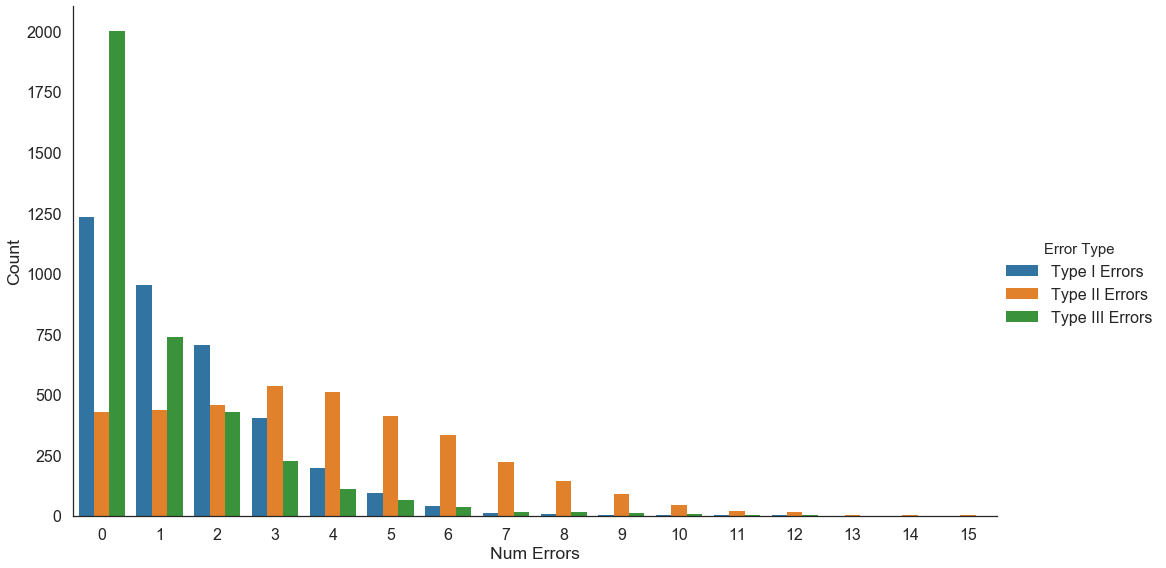

In [85]:
# Make tidier data on error types and check out figures
#    (for own edification)
melted = pd.melt(tidy, value_vars=['Type I Errors', 'Type II Errors', 'Type III Errors'], var_name='Error Type', value_name='Num Errors')

melted['Num Errors Dummy'] = melted['Num Errors']

pivoted = melted.pivot_table(
    index='Num Errors', columns='Error Type', 
    values='Num Errors Dummy', 
    aggfunc=len
)

remelted = pd.melt(
    pivoted, 
    value_vars=['Type I Errors', 'Type II Errors', 'Type III Errors'], 
    value_name='Count'
)

remelted['Num Errors'] = remelted.index.values % 16

g = sns.factorplot(
    x='Num Errors', y='Count', hue='Error Type', 
    data=remelted, 
    kind='bar', legend_out=True,
    size=8, aspect=16/9
)

sns.despine(ax=axes)

### Comments

One alternative to Chi-Sq test could be Kolmogorov-Smirnov test. But I think raw data violate continuous assumption of KS test, as data are relatively low count values in [0, 15]; Chi-Sq is probably more natural choice.

In [8]:
sts.ks_2samp(tidy['Type II Errors'], tidy['Type III Errors'])

Ks_2sampResult(statistic=0.5150767543859649, pvalue=0.0)